In [24]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_context('talk')
warnings.simplefilter("ignore", UserWarning)

## Model Inspection on the Adult Census Dataset

In [25]:
from sklearn.datasets import fetch_openml

adult_census = fetch_openml(data_id=1590, return_frame=True)
# print(adult_census.DESCR)

In [26]:
adult_census.data.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K


In [27]:
from sklearn.model_selection import train_test_split

categorical_columns = ['race', 'occupation', 'workclass']
binary_columns = ['sex']
numerical_columns = ['education-num', 'age', 'hours-per-week']

X = adult_census.data[adult_census.feature_names]
y = adult_census.data[adult_census.target_names].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

## A First Model: Gradient Boosted Trees

In [28]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer


preprocessor = make_column_transformer(
    (SimpleImputer(strategy="median"), numerical_columns),
    (make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"),
                   OrdinalEncoder()), categorical_columns + binary_columns),
    remainder='drop'
)

model = make_pipeline(
    preprocessor,
    HistGradientBoostingClassifier(max_iter=1000, max_leaf_nodes=32,
                                   n_iter_no_change=5, scoring="loss",
                                   tol=1e-4, learning_rate=0.1)
)
%time model.fit(X_train, y_train)
print("Train accuracy score: {:.2f}".format(model.score(X_train, y_train)))
print("Test accuracy score: {:.2f}".format(model.score(X_test, y_test)))

CPU times: user 2.55 s, sys: 11.6 ms, total: 2.57 s
Wall time: 833 ms
Train accuracy score: 0.82
Test accuracy score: 0.82


## Permutation Variable Importances for GBDT

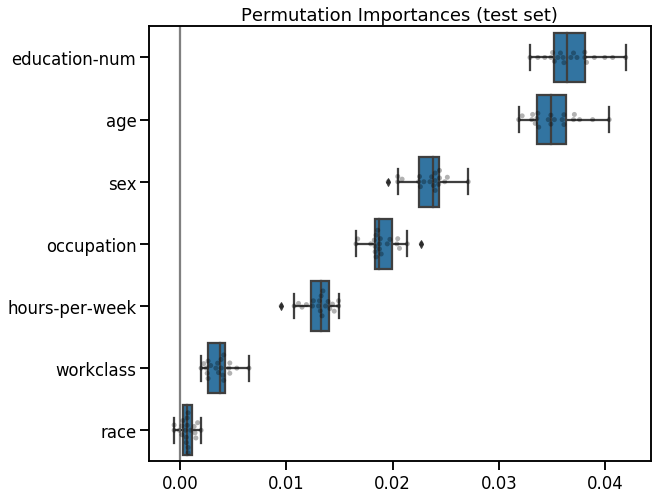

In [29]:
import pandas as pd
from sklearn.inspection import permutation_importance

feature_names = np.concatenate([numerical_columns,
                                categorical_columns,
                                binary_columns])

X_train_preprocessed = (model.named_steps['columntransformer']
                             .transform(X_train))
X_test_preprocessed = (model.named_steps['columntransformer']
                            .transform(X_test))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['histgradientboostingclassifier'],
                           X_test_preprocessed, y_test, n_rounds=20),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (test set)");

## Partial Dependency Plots for GBDT

CPU times: user 1.18 s, sys: 736 ms, total: 1.92 s
Wall time: 1.79 s


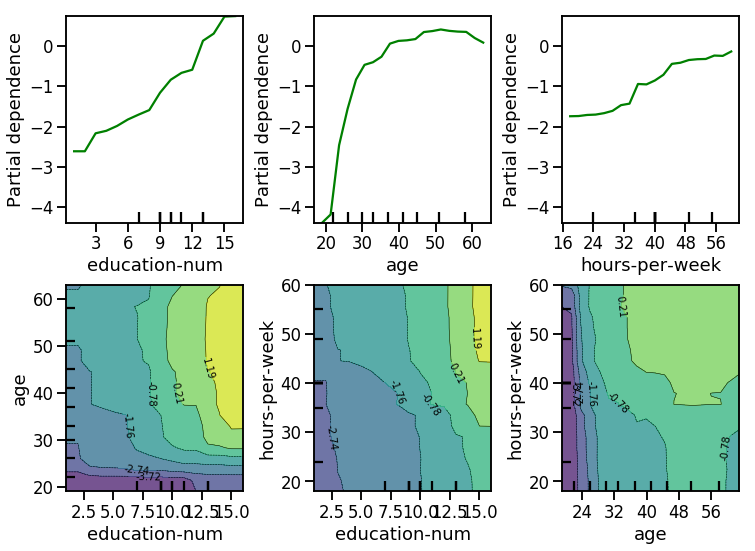

In [30]:
%%time
from sklearn.inspection import plot_partial_dependence


fig = plt.figure(figsize=(11, 12))
features = [0, 1, 2, (0, 1), (0, 2), (1, 2)]
plot_partial_dependence(
    model.named_steps['histgradientboostingclassifier'],
    X_train_preprocessed, features, feature_names=feature_names,
    n_jobs=-1, grid_resolution=20, fig=fig,
)

## Contrasting the Results with a Linear Classifier

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDClassifier


preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy="median"),
                   RobustScaler()), numerical_columns),
    (make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"),
                   OneHotEncoder(sparse=False)), categorical_columns),
    (make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"),
                   OrdinalEncoder()), binary_columns),
    remainder='drop'
)

model = make_pipeline(
    preprocessor,
    SGDClassifier(early_stopping=True, max_iter=10000, n_iter_no_change=10,
                  alpha=1e-3),
)
%time model.fit(X_train, y_train)
print("Train accuracy score: {:.2f}".format(model.score(X_train, y_train)))
print("Test accuracy score: {:.2f}".format(model.score(X_test, y_test)))

CPU times: user 534 ms, sys: 320 ms, total: 853 ms
Wall time: 309 ms


In [ ]:
onehot_names = (model.named_steps['columntransformer']
                      .named_transformers_['pipeline-2']
                      .named_steps['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.concatenate([numerical_columns, onehot_names, binary_columns])

In [ ]:
X_train_preprocessed = (model.named_steps['columntransformer']
                             .transform(X_train))
X_test_preprocessed = (model.named_steps['columntransformer']
                            .transform(X_test))

In [ ]:
%%time
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize=(12, 12))
features = [0, 1, 2, (0, 1), (0, 2), (1, 2)]
plot_partial_dependence(
    model.named_steps['sgdclassifier'],
    X_train_preprocessed, features, feature_names=feature_names,
    n_jobs=-1, grid_resolution=10, fig=fig,
)

## Neural Networks

In [ ]:
from sklearn.neural_network import MLPClassifier

model = make_pipeline(
    preprocessor,
    MLPClassifier(hidden_layer_sizes=(20,),
                  learning_rate_init=0.01,
                  max_iter=1000,
                  early_stopping=True,
                  n_iter_no_change=5,
                  validation_fraction=0.1)
)
%time model.fit(X_train, y_train)
print("Train accuracy score: {:.2f}".format(model.score(X_train, y_train)))
print("Test accuracy score: {:.2f}".format(model.score(X_test, y_test)))

In [ ]:
%%time
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize=(11, 12))
features = [0, 1, 2, (0, 1), (0, 2), (1, 2)]
plot_partial_dependence(
    model.named_steps['mlpclassifier'],
    X_train_preprocessed, features, feature_names=feature_names,
    n_jobs=2, grid_resolution=10, fig=fig,
)